### Используемые библиотеки

In [49]:
library(sva)
library(dplyr)
library(Seurat)
library(tidyverse)
library(sva)
library(limma)
library(readxl)
library(affy)
library(affyio)
library(iSensor)

### Блок 1. Анализ обработанных данных microarrays.

In [3]:
in_path <- "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays/"

In [4]:
microarrays_metadata <- read_excel(paste0(in_path, 'microarrays_metadata.xlsx'))

In [5]:
head(microarrays_metadata)

Phytohormone name,Platform,Ecotype,Duration,Tissue,Growth conditions,Treatment raw samples,Control raw samples,Up-regulated DEG number,Down-regulated DEG number,Reference,Data directory name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Auxin (IAA 5uM),GPL198,Col-0,2h,Seedling,7 DAG,"GSM9574,GSM9575,GSM9576","GSM9571,GSM9572,GSM9573",449,596,PMID: 15659631,auxin_seedling_2h_okushima
Auxin (IAA 10uM),GPL198,Col-0,2h,Root,3 DAG; MS with 10uM NPA,"GSM75509,GSM75513","GSM75508,GSM75512",1922,2202,PMID: 16243906,auxin_root_2h_vanneste
Auxin (IAA 10uM),GPL198,Col-0,6h,Root,3 DAG; MS with 10uM NPA,"GSM75510,GSM75514","GSM75508,GSM75512",4988,4132,PMID: 16243906,auxin_root_6h_vanneste
Auxin (IAA 1uM),GPL198,Col-0,4h,Root,3 DAG; etiolated,"GSM179973,GSM179974","GSM179971,GSM179972",655,1004,PMID: 17630276,auxin_root_4h_stepanova
Auxin (IAA 1uM),GPL198,Col-0,0.5h,Seedling,7 DAG,"GSM469653,GSM469654,GSM469655","GSM469656,GSM469657,GSM469658",1531,1824,PMID: 20622145,auxin_seedling_05h_delker
Auxin (IAA 1uM),GPL198,Col-0,1h,Seedling,7 DAG,"GSM469650,GSM469651,GSM469652","GSM469656,GSM469657,GSM469658",2151,1971,PMID: 20622145,auxin_seedling_1h_delker


In [6]:
folders <- list.dirs(in_path, full.names = TRUE, recursive = FALSE)
files <- list.dirs(in_path, full.names = FALSE, recursive = FALSE)

In [7]:
folders <- folders[!grepl("cauline-buds", folders)]
folders <- folders[!grepl("for stat", folders)]
files <- files[!grepl("cauline-buds", files)]
files <- files[!grepl("for stat", files)]

In [8]:
files

[1] "auxin_leaves_72h_romero-puertas" "auxin_root-apex_6h_xuan"        
 [3] "auxin_root_05h_lewis"            "auxin_root_12h_lewis"           
 [5] "auxin_root_1h_lewis"             "auxin_root_24h_lewis"           
 [7] "auxin_root_2h_bargmann"          "auxin_root_2h_derybel"          
 [9] "auxin_root_2h_lewis"             "auxin_root_2h_vanneste"         
[11] "auxin_root_4h_lewis"             "auxin_root_4h_stepanova"        
[13] "auxin_root_6h_derybel"           "auxin_root_6h_vanneste"         
[15] "auxin_root_8h_lewis"             "auxin_seedling_05h_delker"      
[17] "auxin_seedling_1h_delker"        "auxin_seedling_2h_okushima"     
[19] "auxin_seedling_3h_delker"        "auxin_seedling_3h_shimada"

In [9]:
file_list <- paste0(folders, '/', files, '_counts.txt')

In [10]:
file_list[1:5]

[1] "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays//auxin_leaves_72h_romero-puertas/auxin_leaves_72h_romero-puertas_counts.txt"
[2] "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays//auxin_root-apex_6h_xuan/auxin_root-apex_6h_xuan_counts.txt"                
[3] "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays//auxin_root_05h_lewis/auxin_root_05h_lewis_counts.txt"                      
[4] "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays//auxin_root_12h_lewis/auxin_root_12h_lewis_counts.txt"                      
[5] "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays//auxin_root_1h_lewis/auxin_root_1h_lewis_counts.txt"

In [11]:
data_list <- lapply(file_list, read.table, header = TRUE, sep = "\t")
names(data_list) <- files

#### Не во всех наборах есть Gene.

In [12]:
data_no_Gene_list <- sapply(data_list, function(df) "Gene" %in% colnames(df))

In [13]:
false_names <- names(data_no_Gene_list)[unlist(data_no_Gene_list) == FALSE]

In [14]:
false_names

[1] "auxin_seedling_1h_delker"

In [15]:
colnames(data_list[['auxin_seedling_1h_delker']])[1] <- 'Gene'

#### Соберём информацию для метаданных.

In [16]:
info_list <- str_split(files, '_')

In [17]:
info_list[1:5]

[[1]]
[1] "auxin"          "leaves"         "72h"            "romero-puertas"

[[2]]
[1] "auxin"     "root-apex" "6h"        "xuan"     

[[3]]
[1] "auxin" "root"  "05h"   "lewis"

[[4]]
[1] "auxin" "root"  "12h"   "lewis"

[[5]]
[1] "auxin" "root"  "1h"    "lewis"

In [18]:
info_data <- unlist(sapply(info_list, function(x) x[c(2, 3, 4)]))

#### Преобразуем названия генов.

In [20]:
library(AnnotationDbi)
library(ath1121501.db)

#### У нас в данных есть: <br>
ORF-идентификаторы: orf25, orf149, orf275, ... <br>
AGI-коды: At2g26550, At2g26570, ... <br>
Контрольные зонды Affymetrix: AFFX-Athal-Actin_3, AFFX-Athal-Actin_5, ... <br>
Оставим только AGI.

In [21]:
filter_agi <- function(df) {
  # Регулярное выражение для AGI: At[1-5]g + 5 цифр
  agi_pattern <- "^At[1-5]g\\d{5}$"
  
  # Фильтруем строки, где Gene соответствует паттерну
  df_filtered <- df[grepl(agi_pattern, df$Gene, ignore.case = FALSE), ]
  
  return(df_filtered)
}

In [22]:
data_list <- lapply(data_list, filter_agi)

In [23]:
head(data_list[[1]])

,Gene,X24D_0h_rep1.CEL,X24D_0h_rep2.CEL,X24D_0h_rep3.CEL,X24D_72h_rep1.CEL,X24D_72h_rep2.CEL,X24D_72h_rep3.CEL
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
127,At2g26550,6.921442,6.813428,6.657611,6.249406,6.008416,6.296873
128,At2g26570,7.769886,8.419682,8.101708,8.536509,8.505724,8.690287
129,At2g26580,6.580184,5.927954,6.496062,7.230151,6.173544,6.665122
130,At2g26620,3.557317,3.520668,3.346470,3.370349,3.356752,3.402592
131,At2g26360,5.064977,5.010162,4.818364,4.984104,4.830695,5.006067
132,At2g26630,4.170463,4.192075,4.175932,3.971853,4.094236,4.139550


In [24]:
# Функция для переименования столбцов
rename_cont_treat <- function(df) {
  # Игнорируем первый столбец (Gene)
  data <- df[, -1]
  
  # Определяем количество столбцов
  n <- ncol(data)
  
  # Проверяем, что количество столбцов четное
  if (n %% 2 != 0) {
    stop("Количество столбцов должно быть четным.")
  }
  
  # Переименовываем первую половину
  colnames(data)[1:(n/2)] <- paste0("control_", 1:(n/2))
  
  # Переименовываем вторую половину
  colnames(data)[(n/2 + 1):n] <- paste0("treat_", 1:(n/2))
  
  # Возвращаем измененный data.frame с Gene
  return(cbind(Gene = df$Gene, data))
}

rename_columns <- function(df, df_name) {
  # Игнорируем первый столбец (Gene)
  data <- df[, -1]
  
  # Переименовываем столбцы, добавляя имя data.frame
  colnames(data) <- paste0(colnames(data), "_", df_name)
  
  # Возвращаем измененный data.frame с Gene
  return(cbind(Gene = df$Gene, data))
}

In [25]:
data_list <- lapply(data_list, rename_cont_treat)

In [26]:
names(data_list)

[1] "auxin_leaves_72h_romero-puertas" "auxin_root-apex_6h_xuan"        
 [3] "auxin_root_05h_lewis"            "auxin_root_12h_lewis"           
 [5] "auxin_root_1h_lewis"             "auxin_root_24h_lewis"           
 [7] "auxin_root_2h_bargmann"          "auxin_root_2h_derybel"          
 [9] "auxin_root_2h_lewis"             "auxin_root_2h_vanneste"         
[11] "auxin_root_4h_lewis"             "auxin_root_4h_stepanova"        
[13] "auxin_root_6h_derybel"           "auxin_root_6h_vanneste"         
[15] "auxin_root_8h_lewis"             "auxin_seedling_05h_delker"      
[17] "auxin_seedling_1h_delker"        "auxin_seedling_2h_okushima"     
[19] "auxin_seedling_3h_delker"        "auxin_seedling_3h_shimada"

In [27]:
colnames(data_list[[1]])

[1] "Gene"      "control_1" "control_2" "control_3" "treat_1"   "treat_2"  
[7] "treat_3"

In [28]:
data_list <- lapply(names(data_list), function(name) {
  rename_columns(data_list[[name]], name)
})

In [29]:
names(data_list) <- files

In [30]:
colnames(data_list[[1]])

[1] "Gene"                                     
[2] "control_1_auxin_leaves_72h_romero-puertas"
[3] "control_2_auxin_leaves_72h_romero-puertas"
[4] "control_3_auxin_leaves_72h_romero-puertas"
[5] "treat_1_auxin_leaves_72h_romero-puertas"  
[6] "treat_2_auxin_leaves_72h_romero-puertas"  
[7] "treat_3_auxin_leaves_72h_romero-puertas"

In [31]:
head(data_list[[1]])

,Gene,control_1_auxin_leaves_72h_romero-puertas,control_2_auxin_leaves_72h_romero-puertas,control_3_auxin_leaves_72h_romero-puertas,treat_1_auxin_leaves_72h_romero-puertas,treat_2_auxin_leaves_72h_romero-puertas,treat_3_auxin_leaves_72h_romero-puertas
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
127,At2g26550,6.921442,6.813428,6.657611,6.249406,6.008416,6.296873
128,At2g26570,7.769886,8.419682,8.101708,8.536509,8.505724,8.690287
129,At2g26580,6.580184,5.927954,6.496062,7.230151,6.173544,6.665122
130,At2g26620,3.557317,3.520668,3.346470,3.370349,3.356752,3.402592
131,At2g26360,5.064977,5.010162,4.818364,4.984104,4.830695,5.006067
132,At2g26630,4.170463,4.192075,4.175932,3.971853,4.094236,4.139550


In [32]:
combined_data <- Reduce(function(x, y) merge(x, y, by = "Gene", all = TRUE), data_list)

In [33]:
combined_data[['Gene']] <- toupper(combined_data[['Gene']])

In [34]:
head(combined_data)

,Gene,control_1_auxin_leaves_72h_romero-puertas,control_2_auxin_leaves_72h_romero-puertas,control_3_auxin_leaves_72h_romero-puertas,treat_1_auxin_leaves_72h_romero-puertas,treat_2_auxin_leaves_72h_romero-puertas,treat_3_auxin_leaves_72h_romero-puertas,control_1_auxin_root-apex_6h_xuan,control_2_auxin_root-apex_6h_xuan,control_3_auxin_root-apex_6h_xuan,...,control_3_auxin_seedling_3h_delker,treat_1_auxin_seedling_3h_delker,treat_2_auxin_seedling_3h_delker,treat_3_auxin_seedling_3h_delker,control_1_auxin_seedling_3h_shimada,control_2_auxin_seedling_3h_shimada,control_3_auxin_seedling_3h_shimada,treat_1_auxin_seedling_3h_shimada,treat_2_auxin_seedling_3h_shimada,treat_3_auxin_seedling_3h_shimada
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AT1G01010,6.623191,6.212545,5.838166,6.433437,7.237592,6.975712,5.441316,5.218473,5.203509,...,5.309353,5.832827,5.955281,5.683726,7.107082,7.097536,6.902747,7.290371,7.417129,6.263441
2,AT1G01030,6.124320,5.316210,5.829162,4.908924,4.651088,4.511345,2.729205,2.724356,2.453665,...,4.404529,4.111322,3.946351,3.987529,6.208076,5.460400,5.678680,5.672612,5.587996,5.192637
3,AT1G01040,7.237873,7.557557,6.686809,7.072883,7.228713,7.127913,6.234159,6.204925,6.131813,...,6.358865,6.011589,6.189829,6.261399,7.759621,7.726540,7.712791,7.641632,7.644585,8.692015
4,AT1G01050,10.767287,10.768734,10.544253,10.514223,10.507143,10.300173,10.056022,9.877912,10.046006,...,9.999807,9.950178,9.932152,10.004661,10.361984,10.778680,10.734013,10.765573,10.721552,10.002266
5,AT1G01060,11.429358,11.380498,10.776630,11.963115,11.603296,11.443358,4.414366,4.186377,4.163916,...,9.653599,7.949180,7.865727,7.918847,9.508925,9.078638,9.109707,9.375625,8.940431,8.962679
6,AT1G01070,4.494710,4.687553,4.802124,7.057657,7.074774,7.452142,5.929837,5.722836,5.318633,...,6.105308,6.862488,6.666062,6.688831,7.297923,7.799854,7.834965,8.055154,8.142145,8.264064


In [35]:
expression_matrix <- as.matrix(combined_data[,-1])  # Удалите колонку с идентификаторами генов

In [36]:
rownames(expression_matrix) <- combined_data[['Gene']]

In [37]:
head(expression_matrix)

,control_1_auxin_leaves_72h_romero-puertas,control_2_auxin_leaves_72h_romero-puertas,control_3_auxin_leaves_72h_romero-puertas,treat_1_auxin_leaves_72h_romero-puertas,treat_2_auxin_leaves_72h_romero-puertas,treat_3_auxin_leaves_72h_romero-puertas,control_1_auxin_root-apex_6h_xuan,control_2_auxin_root-apex_6h_xuan,control_3_auxin_root-apex_6h_xuan,treat_1_auxin_root-apex_6h_xuan,...,control_3_auxin_seedling_3h_delker,treat_1_auxin_seedling_3h_delker,treat_2_auxin_seedling_3h_delker,treat_3_auxin_seedling_3h_delker,control_1_auxin_seedling_3h_shimada,control_2_auxin_seedling_3h_shimada,control_3_auxin_seedling_3h_shimada,treat_1_auxin_seedling_3h_shimada,treat_2_auxin_seedling_3h_shimada,treat_3_auxin_seedling_3h_shimada
AT1G01010,6.623191,6.212545,5.838166,6.433437,7.237592,6.975712,5.441316,5.218473,5.203509,5.438824,...,5.309353,5.832827,5.955281,5.683726,7.107082,7.097536,6.902747,7.290371,7.417129,6.263441
AT1G01030,6.124320,5.316210,5.829162,4.908924,4.651088,4.511345,2.729205,2.724356,2.453665,2.525577,...,4.404529,4.111322,3.946351,3.987529,6.208076,5.460400,5.678680,5.672612,5.587996,5.192637
AT1G01040,7.237873,7.557557,6.686809,7.072883,7.228713,7.127913,6.234159,6.204925,6.131813,6.423900,...,6.358865,6.011589,6.189829,6.261399,7.759621,7.726540,7.712791,7.641632,7.644585,8.692015
AT1G01050,10.767287,10.768734,10.544253,10.514223,10.507143,10.300173,10.056022,9.877912,10.046006,9.954235,...,9.999807,9.950178,9.932152,10.004661,10.361984,10.778680,10.734013,10.765573,10.721552,10.002266
AT1G01060,11.429358,11.380498,10.776630,11.963115,11.603296,11.443358,4.414366,4.186377,4.163916,4.386866,...,9.653599,7.949180,7.865727,7.918847,9.508925,9.078638,9.109707,9.375625,8.940431,8.962679
AT1G01070,4.494710,4.687553,4.802124,7.057657,7.074774,7.452142,5.929837,5.722836,5.318633,6.431524,...,6.105308,6.862488,6.666062,6.688831,7.297923,7.799854,7.834965,8.055154,8.142145,8.264064


#### Обработка исходных данных с помощью Seurat

In [38]:
illustr_dir <- 'illustrations/'

In [39]:
seurat_obj <- CreateSeuratObject(counts = expression_matrix, project = "microarrays_raw")

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [50]:
# Create metadata dataframe
sample_info <- data.frame(
    Batch = batch,
    Type = unname(result_vector),
    Tissue = c(rep(info_data[1,], sample_counts)),
    Duration = c(rep(info_data[2,], sample_counts)),
    Author = c(rep(info_data[3,], sample_counts)),
    row.names = colnames(expression)
)

In [42]:
library(RColorBrewer)

In [107]:
hex_colors <- c("#f46d43", "#74add1")

In [80]:
hex_colors <- c('#d73027', '#fdae61', '#abd9e9', '#4575b4')

In [85]:
brewer.pal(n = 10, name = "RdYlBu")

[1] "#A50026" "#D73027" "#F46D43" "#FDAE61" "#FEE090" "#E0F3F8" "#ABD9E9"
 [8] "#74ADD1" "#4575B4" "#313695"

In [60]:
# DimPlot(seurat_obj, reduction = "umap", group.by = "Tissue", cols=brewer.pal(n = 4, name = "RdYlBu"))  # PCA colored by sample

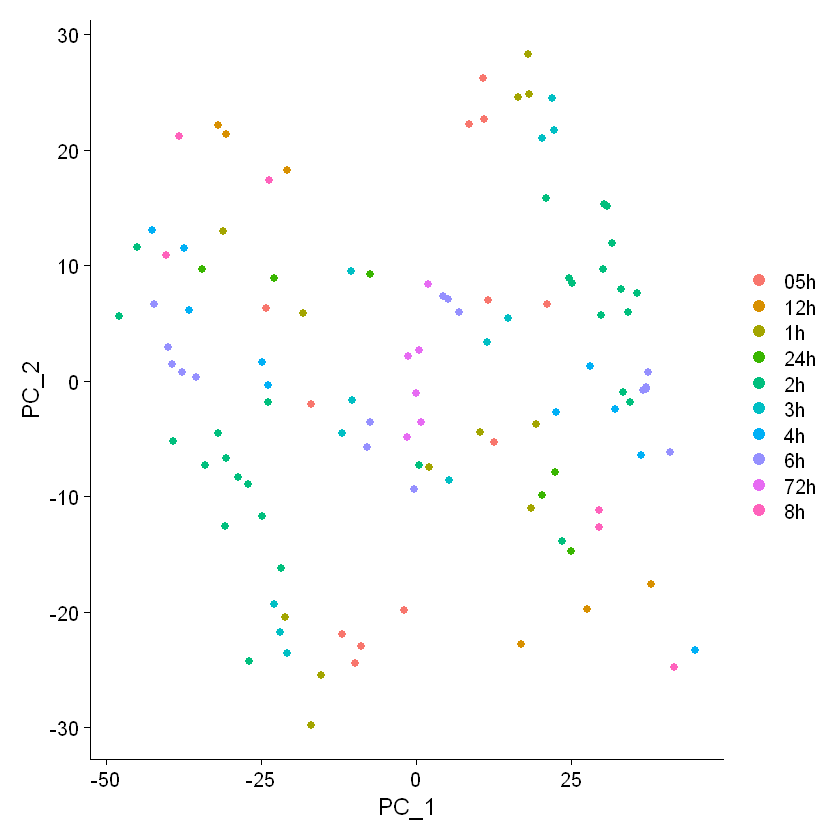

In [79]:
DimPlot(seurat_obj, reduction = "pca", group.by = "Duration", pt.size = 2) + ggtitle(NULL)

In [110]:
p <- DimPlot(seurat_obj, reduction = "umap", group.by = "Type", cols=hex_colors, pt.size = 2) + ggtitle('microarrays raw')

In [111]:
ggsave(paste0(illustr_dir, '1/aux_microarr_raw_type.png'), plot = p, width = 8, height = 8)

#### Делаем batch-коррекцию

In [40]:
batch_names <- gsub("\\.txt$", "", basename(files))

In [41]:
batch_names

[1] "auxin_leaves_72h_romero-puertas" "auxin_root-apex_6h_xuan"        
 [3] "auxin_root_05h_lewis"            "auxin_root_12h_lewis"           
 [5] "auxin_root_1h_lewis"             "auxin_root_24h_lewis"           
 [7] "auxin_root_2h_bargmann"          "auxin_root_2h_derybel"          
 [9] "auxin_root_2h_lewis"             "auxin_root_2h_vanneste"         
[11] "auxin_root_4h_lewis"             "auxin_root_4h_stepanova"        
[13] "auxin_root_6h_derybel"           "auxin_root_6h_vanneste"         
[15] "auxin_root_8h_lewis"             "auxin_seedling_05h_delker"      
[17] "auxin_seedling_1h_delker"        "auxin_seedling_2h_okushima"     
[19] "auxin_seedling_3h_delker"        "auxin_seedling_3h_shimada"

In [42]:
sample_counts <- sapply(data_list, ncol) - 1

In [43]:
sample_counts

auxin_leaves_72h_romero-puertas         auxin_root-apex_6h_xuan 
                              6                               6 
           auxin_root_05h_lewis            auxin_root_12h_lewis 
                              6                               6 
            auxin_root_1h_lewis            auxin_root_24h_lewis 
                              6                               6 
         auxin_root_2h_bargmann           auxin_root_2h_derybel 
                              6                               6 
            auxin_root_2h_lewis          auxin_root_2h_vanneste 
                              6                               4 
            auxin_root_4h_lewis         auxin_root_4h_stepanova 
                              6                               4 
          auxin_root_6h_derybel          auxin_root_6h_vanneste 
                              6                               4 
            auxin_root_8h_lewis       auxin_seedling_05h_delker 
                              6                               6 
       auxin_seedling_1h_delker      auxin_seedling_2h_okushima 
                              6                               6 
       auxin_seedling_3h_delker       auxin_seedling_3h_shimada 
                              6                               6

In [44]:
batch <- factor(rep(batch_names, times = sample_counts))

#### Разделили по экспериментам

In [63]:
normalized_counts <- normalizeBetweenArrays(expression_matrix)

In [64]:
corrected_data <- ComBat(dat = normalized_counts, batch = batch)

Found 7 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found20batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




#### Стандартная обработка с помощью Seurat.

In [65]:
seurat_obj <- CreateSeuratObject(counts = corrected_data, project = "microarrays")

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [53]:
info_data

leaves,root-apex,root,root,root,root,root,root,root,root,root,root,root,root,root,seedling,seedling,seedling,seedling,seedling
72h,6h,05h,12h,1h,24h,2h,2h,2h,2h,4h,4h,6h,6h,8h,05h,1h,2h,3h,3h
romero-puertas,xuan,lewis,lewis,lewis,lewis,bargmann,derybel,lewis,vanneste,lewis,stepanova,derybel,vanneste,lewis,delker,delker,okushima,delker,shimada


In [45]:
# Создание вектора
result_vector <- unlist(sapply(sample_counts, function(x) {
  half_value <- x / 2
  c(rep("control", half_value), rep("treat", half_value))
}))

In [46]:
length(unname(result_vector))

[1] 114

In [47]:
length(batch)

[1] 114

In [66]:
# Create metadata dataframe
sample_info <- data.frame(
    Batch = batch,
    Type = unname(result_vector),
    Tissue = c(rep(info_data[1,], sample_counts)),
    Duration = c(rep(info_data[2,], sample_counts)),
    Author = c(rep(info_data[3,], sample_counts)),
    row.names = colnames(corrected_data)
)

In [67]:
# Add metadata to Seurat object
seurat_obj <- AddMetaData(seurat_obj, metadata = sample_info)

In [68]:
# Normalize the data (optional step based on your analysis)
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [69]:
# Find variable features (for downstream analysis)
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



In [70]:
# Scaling the data (for PCA and clustering)
seurat_obj <- ScaleData(seurat_obj, features = rownames(seurat_obj))

Centering and scaling data matrix



In [71]:
# Perform PCA
num_pcs <- min(30, ncol(seurat_obj) - 1)  # Avoid PCA error if columns are fewer than PCs
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj), npcs = num_pcs)

PC_ 1 
Positive:  AT1G72200, AT5G57150, AT2G25160, AT4G12510, AT2G16980, AT5G47450, AT5G56870, AT4G39350, AT5G49360, AT4G23400 
	   AT5G26655, AT2G36430, AT2G16850, AT1G76890, AT3G45070, AT3G61430, AT2G16970, AT3G20015, AT1G19900, AT4G30460 
	   AT2G35470, AT1G01620, AT2G30510, AT2G45960, AT3G53100, AT1G24440, AT2G44940, AT3G45700, AT5G56540, AT1G14290 
Negative:  AT4G37295, AT2G45420, AT1G31650, AT3G07390, AT5G51380, AT1G33790, AT2G03830, AT2G28690, AT1G34110, AT3G10870 
	   AT5G65320, AT1G66480, AT4G17350, AT2G03730, AT1G54990, AT3G13380, AT2G23060, AT5G18560, AT2G45400, AT3G03170 
	   AT2G14960, AT3G28850, AT4G30140, AT3G16500, AT4G13195, AT2G03850, AT1G55610, AT1G75640, AT2G47140, AT3G27580 
PC_ 2 
Positive:  AT4G28270, AT1G44050, AT4G17870, AT5G28770, AT1G78020, AT5G56100, AT2G46690, AT4G10270, AT3G10040, AT3G23880 
	   AT2G23590, AT5G03230, AT5G01600, AT5G61420, AT1G72360, AT1G10640, AT2G38400, AT3G13760, AT2G37460, AT5G53880 
	   AT2G19980, AT5G59780, AT1G74940, AT5G48490, AT5G6

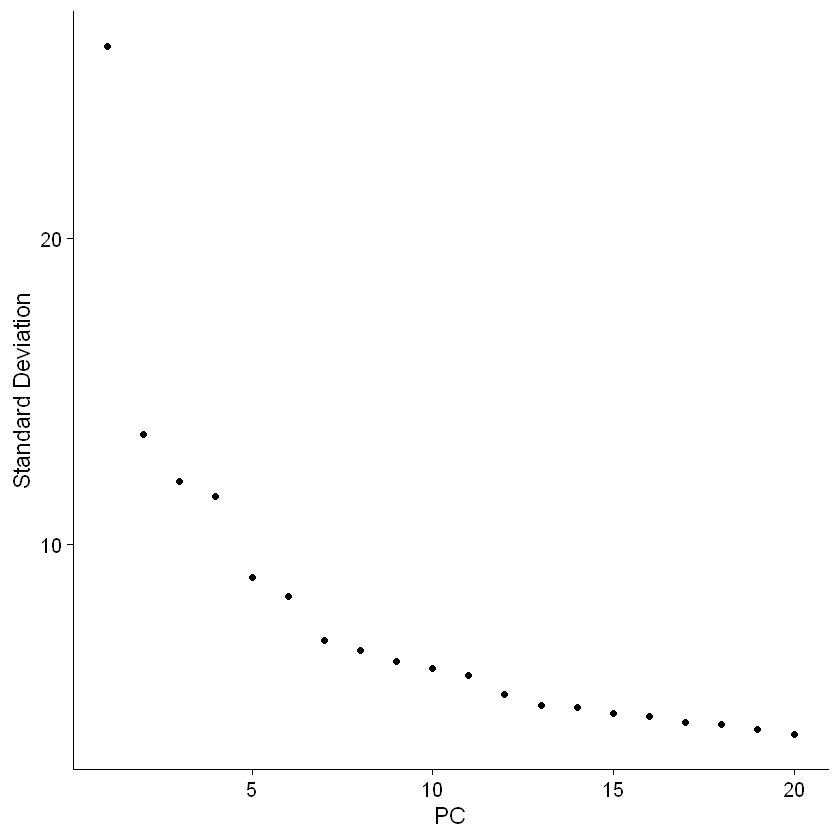

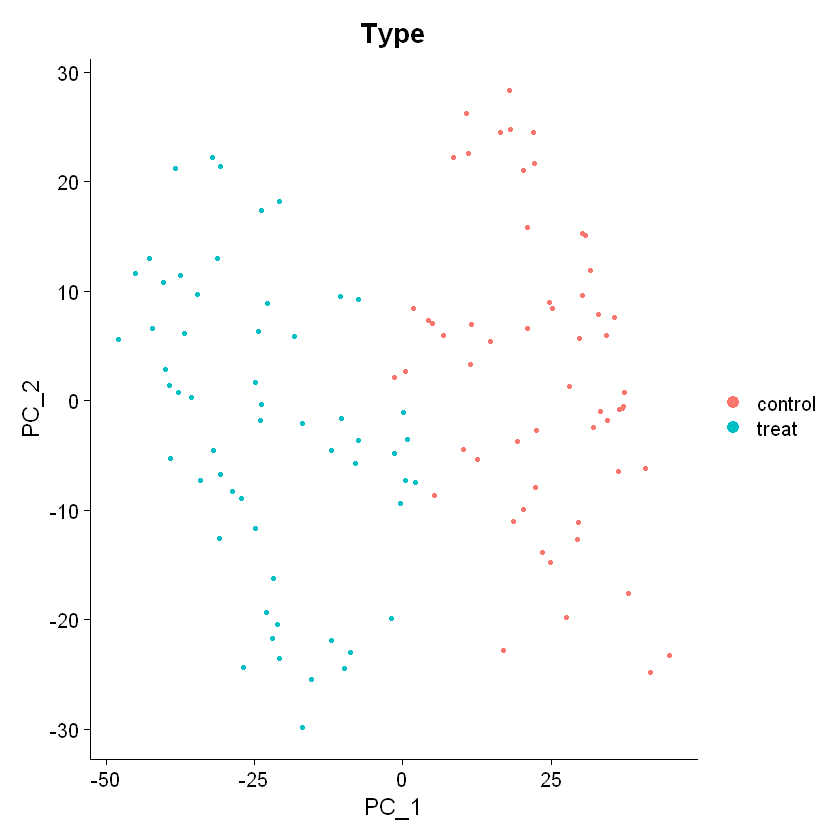

In [130]:
# Visualize PCA results
ElbowPlot(seurat_obj)  # Determine the number of PCs to use
DimPlot(seurat_obj, reduction = "pca", group.by = "Type")  # PCA colored by sample

In [72]:
# Run UMAP (Uniform Manifold Approximation and Projection)
# Determine the number of available samples
num_samples <- ncol(seurat_obj)

In [73]:
# Run UMAP with adjusted parameters
seurat_obj <- RunUMAP(
  seurat_obj, 
  dims = 1:num_pcs, 
  reduction = "pca",  # Ensure it uses PCA
  n.neighbors = min(10, num_samples - 1),  # Ensuring it's within the correct limit
  umap.method = 'uwot', 
  metric = 'cosine'  # Recommended for gene expression data
)

10:46:15 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

10:46:15 Read 114 rows and found 30 numeric columns

10:46:15 Using Annoy for neighbor search, n_neighbors = 10

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

10:46:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:46:15 Writing NN index file to temp file C:\Users\user\AppData\Local\Temp\RtmpQ3Rb6N\file1de0405479ba

10:46:15 Searching Annoy index using 1 thread, search_k = 1000

10:46:15 Annoy recall = 100%

10:46:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 10

10:46:16 Initializing fr

In [58]:
paste0(in_path, "\\seurat_auxin_microarrays_no_cb.rds")

[1] "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays/\\seurat_auxin_microarrays_no_cb.rds"

In [134]:
saveRDS(seurat_obj, file = paste0(in_path, "\\seurat_auxin_microarrays_no_cb.rds"))

In [74]:
saveRDS(seurat_obj, file = paste0(illustr_dir, "seurat_auxin_microarrays_no_cb.rds"))

#### Рисуем картинки.

In [136]:
library(patchwork)
library(cowplot)
library(ggplot2)

In [214]:
# Visualize UMAP results
p1 <- DimPlot(seurat_obj, reduction = "umap", label = F, pt.size = 2)
p1 <- p1 + theme(legend.position = "none")
p2 <- DimPlot(seurat_obj, reduction = "umap", label = T, pt.size = 2)
p2 <- p2 + theme(legend.position = "none")
combined_plot <- p1 + p2 + plot_layout(ncol = 2, widths = c(1, 1))

In [137]:
p1 <- DimPlot(seurat_obj, reduction = "umap", group.by = "Type",  label = T, pt.size = 2, repel = T)
p2 <- DimPlot(seurat_obj, reduction = "umap", group.by = "Tissue",  label = T, pt.size = 2, repel = T)
p3 <- DimPlot(seurat_obj, reduction = "umap", group.by = "Duration",  label = T, pt.size = 2, repel = T)
p4 <- DimPlot(seurat_obj, reduction = "umap", group.by = "Author",  label = T, pt.size = 2, repel = T)
combined_plot <- p1 + p2 + p3 + p4 + plot_layout(ncol = 2, widths = c(2, 2))

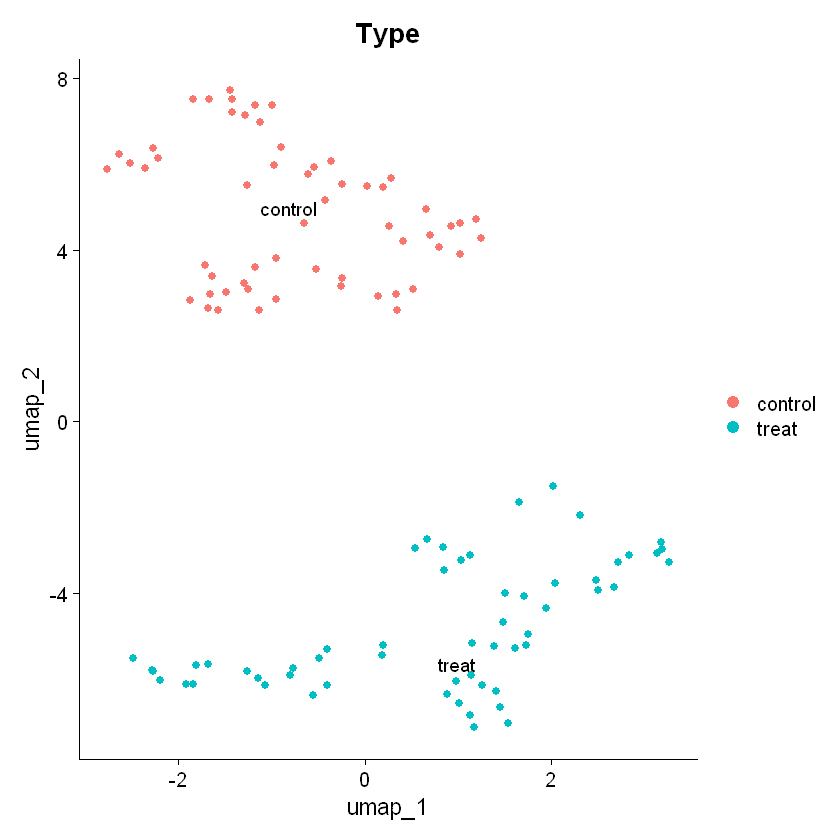

In [140]:
p1

In [141]:
ggsave("UMAP_microarrays_no_cb_all.png", plot = combined_plot, width = 12, height = 12)

#### По бачам почему-то не строит

In [219]:
DimPlot(seurat_obj, reduction = "umap", group.by = "Batch",  label = T, pt.size = 2, repel = T)

ERROR while rich displaying an object: Error in grid.Call(C_convert, x, as.integer(whatfrom), as.integer(whatto), : Оконница имеет ноль измерений

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7.

### Блок 2. Сырые данные.

In [76]:
cel_files_cel <- list.files(path = "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays_raw/treat/", pattern = "*cel.gz", full.names = TRUE)
cel_files_CEL <- list.files(path = "D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays_raw/treat/", pattern = "*CEL.gz", full.names = TRUE)

In [78]:
cel_files <- c(cel_files_cel, cel_files_CEL)

In [79]:
data_raw <- ReadAffy(filenames = cel_files)

In [191]:
gene_names <- featureNames(data_raw)

In [81]:
exprs_matrix <- exprs(data_raw)

In [83]:
head(exprs_matrix)

,GSM9574.cel.gz,GSM9575.cel.gz,GSM9576.cel.gz,GSM1030567_T1-10_10_IAA0.5_1_ATH1-121501.CEL.gz,GSM1030568_T1-11_11_IAA1_1_ATH1-121501.CEL.gz,GSM1030569_T1-12_36_IAA2_1_ATH1-121501.CEL.gz,GSM1030570_T1-13_37_IAA4_1_ATH1-121501.CEL.gz,GSM1030571_T1-14_38_IAA8_1_ATH1-121501.CEL.gz,GSM1030572_T1-15_39_IAA12_1_ATH1-121501.CEL.gz,GSM1030573_T1-24_48_IAA24_1_ATH1-121501.CEL.gz,...,GSM5414002_Wt_72h_1.CEL.gz,GSM5414003_Wt_72h_2.CEL.gz,GSM5414004_Wt_72h_3.CEL.gz,GSM75509.CEL.gz,GSM75510.CEL.gz,GSM75513.CEL.gz,GSM75514.CEL.gz,GSM871269.CEL.gz,GSM871270.CEL.gz,GSM871271.CEL.gz
1,111.0,154.5,95.0,227.0,283.0,232.0,349.0,226,272,268.0,...,114.0,108.0,124.0,233.5,232.3,155.0,226.3,123.0,159.0,99.0
2,10173.8,10617.0,8833.3,26749.0,30777.0,31548.0,27216.0,26927,27706,28876.0,...,21386.0,21309.0,19747.0,14949.5,13584.0,15413.5,14201.5,8882.0,11779.0,7471.0
3,164.8,185.3,126.0,263.8,320.3,346.3,395.5,285,292,275.5,...,130.5,145.8,116.8,239.3,187.3,256.5,191.0,172.8,214.3,122.5
4,10225.8,10853.0,8535.3,25868.0,29823.0,30943.0,28051.0,26747,28725,28810.8,...,21711.0,20679.0,18388.0,14975.8,14060.0,15985.3,14553.8,9052.0,12349.0,7286.0
5,122.8,272.5,94.3,98.0,112.0,197.0,200.0,173,159,134.0,...,103.0,94.0,93.0,119.0,92.8,121.5,102.5,92.0,92.0,78.0
6,108.3,165.8,82.3,155.0,204.0,199.0,162.0,168,234,195.0,...,102.0,101.8,112.0,201.0,137.5,145.0,223.3,95.0,127.0,75.0


In [80]:
slotNames(data_raw)

[1] "cdfName"           "nrow"              "ncol"             
 [4] "assayData"         "phenoData"         "featureData"      
 [7] "experimentData"    "annotation"        "protocolData"     
[10] ".__classVersion__"

In [99]:
slotNames(data_raw@featureData@data)

[1] ".Data"     "names"     "row.names" ".S3Class"

In [102]:
data_raw@featureData@data@.Data

list()

In [91]:
str(data_raw)

Formal class 'AffyBatch' [package "affy"] with 10 slots
  ..@ cdfName          : chr "ATH1-121501"
  ..@ nrow             : Named int 712
  .. ..- attr(*, "names")= chr "Rows"
  ..@ ncol             : Named int 712
  .. ..- attr(*, "names")= chr "Cols"
  ..@ assayData        :<environment: 0x0000000061623a60> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  .. .. ..@ varMetadata      :'data.frame':	1 obs. of  1 variable:
  .. .. .. ..$ labelDescription: chr "arbitrary numbering"
  .. .. ..@ data             :'data.frame':	60 obs. of  1 variable:
  .. .. .. ..$ sample: int [1:60] 1 2 3 4 5 6 7 8 9 10 ...
  .. .. ..@ dimLabels        : chr [1:2] "sampleNames" "sampleColumns"
  .. .. ..@ .__classVersion__:Formal class 'Versions' [package "Biobase"] with 1 slot
  .. .. .. .. ..@ .Data:List of 1
  .. .. .. .. .. ..$ : int [1:3] 1 1 0
  .. .. .. .. ..$ names: chr "AnnotatedDataFrame"
  ..@ featureData      :Formal class 'AnnotatedDataFrame' [packa

In [90]:
data_raw@annotation

[1] "ath1121501"

In [ ]:
data_raw

In [69]:
data_raw <- ReadAffy(filenames = 'D://FILES/work/Sensor/ISensors_data/Auxin_transcriptoms/microarrays_raw/treat/GSM9574.cel.gz')

### Артефакты...

In [25]:
agi_ids <- mapIds(
  ath1121501.db, 
  keys = rownames(data_list[['auxin_seedling_1h_delker']]),  # Ваши probe IDs
  keytype = "PROBEID",               # Тип исходных идентификаторов
  column = "TAIR",                   # Колонка с AGI-кодами (для Arabidopsis)
  multiVals = "list"                 # Как обрабатывать множественные сопоставления
)

'select()' returned 1:many mapping between keys and columns



In [26]:
agi_ids <- unlist(agi_ids)

In [30]:
length(rownames(data_list[['auxin_seedling_1h_delker']]))

[1] 22810

In [31]:
length(agi_ids)

[1] 23755

In [32]:
agi_ids <- agi_ids[!is.na(agi_ids) & lengths(agi_ids) == 1]
# expression_data <- expression_data[names(agi_ids), ]

In [33]:
agi_ids <- sapply(agi_ids, function(x) x[1])

In [ ]:
rownames(expression_data) <- agi_ids

# Удалите строки с NA (если есть)
expression_data <- expression_data[!is.na(rownames(expression_data)), ]